In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from tqdm import tqdm

import qulacs
from qulacs import QuantumState, QuantumCircuit
from qulacs.gate import CZ, RX, RY, RZ, merge
from qulacs import Observable
from qulacs.observable import create_observable_from_openfermion_text
from qulacsvis import circuit_drawer
from openfermion.ops import QubitOperator
from openfermion.transforms import get_fermion_operator, jordan_wigner
from openfermion.linalg import get_sparse_operator
from openfermion.chem import MolecularData
from openfermionpyscf import run_pyscf
from pyscf import fci

### Ansatz

Reference: A. Kandala _et. al._ , “Hardware-efficient variational quantum eigensolver for small molecules and quantum magnets“, Nature **549**, 242–246)

In [2]:
def he_ansatz_circuit(n_qubit, depth, theta_list):
    circuit = QuantumCircuit(n_qubit)
    for i in range(n_qubit):
        circuit.add_gate(merge(RX(i, theta_list[2*i+3*n_qubit*depth]), RZ(i, theta_list[2*i+1+3*n_qubit*depth])))
    for d in range(depth):
        for i in range(n_qubit//2):
            circuit.add_gate(CZ(2*i, 2*i+1))
        for i in range(n_qubit//2-1):
            circuit.add_gate(CZ(2*i+1, 2*i+2))
        for i in range(n_qubit):
            circuit.add_gate(merge(merge(RZ(i, theta_list[2*i+3*n_qubit*d]), RX(i, theta_list[2*i+1+3*n_qubit*d])),RZ(i, theta_list[2*i+3*n_qubit*d])))
    
    return circuit

In [3]:
basis = "sto-3g"
multiplicity = 1
charge = 0
description  = "tmp"

def molecule(r):
    geometry = [["H", [0,0,0]],["H", [0,0,r]]]
    molecule = MolecularData(geometry, basis, multiplicity, charge, description)
    molecule = run_pyscf(molecule,run_scf=1,run_fci=1)
    n_qubit = molecule.n_qubits
    n_electron = molecule.n_electrons
    fermionic_hamiltonian = get_fermion_operator(molecule.get_molecular_hamiltonian())
    jw_hamiltonian = jordan_wigner(fermionic_hamiltonian)
    qulacs_hamiltonian = create_observable_from_openfermion_text(str(jw_hamiltonian))
    
    return n_qubit, qulacs_hamiltonian, jw_hamiltonian

In [5]:
print(get_sparse_operator(molecule(0.74)[2]))

  (0, 0)	(0.7151043390810812+0j)
  (1, 1)	(0.24003549030890364+0j)
  (2, 2)	(0.24003549030890373+0j)
  (3, 3)	(0.46261814602718965+0j)
  (12, 3)	(0.18121046201519708+0j)
  (4, 4)	(-0.5382054475648965+0j)
  (5, 5)	(-0.5307733570014577+0j)
  (6, 6)	(-0.3495628949862604+0j)
  (9, 6)	(-0.18121046201519708+0j)
  (7, 7)	(0.3555207000676419+0j)
  (8, 8)	(-0.5382054475648967+0j)
  (6, 9)	(-0.18121046201519708+0j)
  (9, 9)	(-0.3495628949862605+0j)
  (10, 10)	(-0.5307733570014577+0j)
  (11, 11)	(0.3555207000676418+0j)
  (3, 12)	(0.18121046201519708+0j)
  (12, 12)	(-1.1167593073964257+0j)
  (13, 13)	(-0.4456158154821734+0j)
  (14, 14)	(-0.4456158154821733+0j)
  (15, 15)	(0.9231791809225427+0j)


In [24]:
def get_exp(state, theta_list, n_qubit, depth, hamiltonian):
    circuit = he_ansatz_circuit(n_qubit, depth, theta_list)
    circuit.update_quantum_state(state)
    return hamiltonian.get_expectation_value(state)

def cost(theta_list, n_qubit, depth, hamiltonian):
    state0 = QuantumState(n_qubit)
    state1 = QuantumState(n_qubit); state1.set_computational_basis(1)
    #state2 = QuantumState(n_qubit); state2.set_computational_basis(2)
    #state3 = QuantumState(n_qubit); state3.set_computational_basis(3)
    return get_exp(state0, theta_list, n_qubit, depth, hamiltonian)+0.4*get_exp(state1, theta_list, n_qubit, depth, hamiltonian)
    #return get_exp(state0, theta_list, n_qubit, depth, hamiltonian)+0.5*get_exp(state1, theta_list, n_qubit, depth, hamiltonian)+0.3*get_exp(state2, theta_list, n_qubit, depth, hamiltonian)+0.1*get_exp(state3, theta_list, n_qubit, depth, hamiltonian)
    
#init_theta_list = np.random.random(2*4*(4+1)+2)*1e-1
#cost(init_theta_list)

In [25]:
number = 41
r_initial = 0.165
r_final = 4.0
r_list = []
energies_g = []
energies_e1 = []
energies_e2 = []
energies_e3 = []
#depth = 1

method = "BFGS"
options = {"gtol": 1e-9}
#options = {"disp": True, "gtol": 1e-6}

init_theta_list = 2*np.pi*np.random.random(3*molecule(0.5)[0]*molecule(0.5)[0]+2*molecule(0.5)[0])

for i in tqdm(range(number)):
    r = r_initial+i*(r_final-r_initial)/(number-1)
    n_qubit = molecule(r)[0]
    depth = n_qubit
    hamiltonian = molecule(r)[1]
    state0 = QuantumState(n_qubit)
    state1 = QuantumState(n_qubit); state1.set_computational_basis(1)
    #state2 = QuantumState(n_qubit); state2.set_computational_basis(2)
    #state3 = QuantumState(n_qubit); state3.set_computational_basis(3)

    opt = minimize(lambda theta: cost(theta, n_qubit, depth, hamiltonian), init_theta_list, method=method, options=options)
    
    r_list.append(r)
    energies_g.append(get_exp(state0, opt.x, n_qubit, depth, hamiltonian))
    energies_e1.append(get_exp(state1, opt.x, n_qubit, depth, hamiltonian))
    #energies_e2.append(get_exp(state2, opt.x, n_qubit, depth, hamiltonian))
    #energies_e3.append(get_exp(state3, opt.x, n_qubit, depth, hamiltonian))

100%|██████████| 41/41 [13:47<00:00, 20.18s/it]


In [27]:
r_min = 0
E_min = 0
index = 0

for j in range(len(energies_g)):
    if energies_g[j] < E_min:
        r_min = r_list[j]
        E_min = energies_g[j]
        index = j

print(r_min)
print(E_min)
print(index)

0.74025
-1.1372816304260425
6


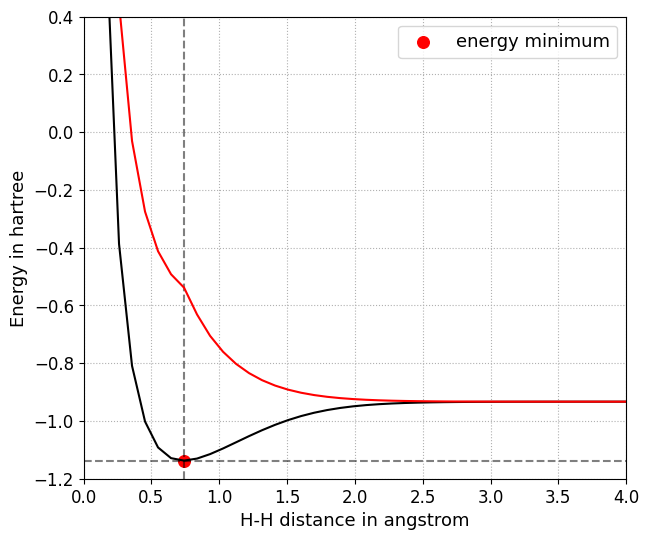

In [28]:
plt.figure(figsize=(7.0, 6.0))

xmin_plot, xmax_plot = 0, 4
ymin_plot, ymax_plot = -1.2, 0.4
plt.xlim(xmin_plot, xmax_plot)
plt.ylim(ymin_plot, ymax_plot)

plt.xticks(fontsize=12, rotation=0)
plt.yticks(fontsize=12, rotation=0)
plt.xlabel("H-H distance in angstrom", fontsize=13)
plt.ylabel("Energy in hartree", fontsize=13)
plt.grid(linestyle='dotted')

plt.axvline(r_min, color="black", linestyle="dashed", alpha=0.5)
plt.axhline(E_min, color="black", linestyle="dashed", alpha=0.5)

plt.plot(r_list, energies_g, color="black", linestyle="solid")
plt.plot(r_list, energies_e1, color="red", linestyle="solid")
#plt.plot(r_list, energies_e2, color="red", linestyle="solid")
#plt.plot(r_list, energies_e3, color="red", linestyle="solid")
plt.scatter(r_min, E_min, c ="red", s=70, alpha=1.0, label="energy minimum")

plt.legend(loc='best', fontsize=13)
plt.show()